# Gaussian simulations

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Preamble

In this preamble, we load the **gstlearn** library.

In [3]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

gp.setDefaultGeographic(dims=[8,8])

We load two data bases:

* a data base `dat` containing point observations of two variables across Scotland: the elevation (`Elevation`) and the temperature (`January_temp`)
* a data base `target` containing a grid of points covering Scotland with a selection variable (`inshore`) selecting the points that are on land, and a variable (`Elevation`) giving the elevation at every point on land

In [4]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Temperatures.NF'
temp_nf, head = urllib.request.urlretrieve(url)
dat = gl.Db.createFromNF(temp_nf)

url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Elevations.NF'
elev_nf, head = urllib.request.urlretrieve(url)
target = gl.DbGrid.createFromNF(elev_nf)

We also compute an experimental variogram on the observations and fit a model on it.

In [5]:
## Define and compute experimental variogram
varioparam = gl.VarioParam.createOmniDirection(npas=40, dpas=10)
vario_raw2dir = gl.Vario.create(varioparam, dat)
vario_raw2dir.compute()

## Fit model
fitmod = gl.Model()
err = fitmod.fit(vario_raw2dir, types=[gl.ECov.NUGGET, gl.ECov.SPHERICAL, gl.ECov.CUBIC])
fitmod.display()


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Spherical
- Sill         =      1.155
- Range        =    135.133
Total Sill     =      1.155
 

In [6]:
neighU = gl.NeighUnique.create()

ndim = 2
gl.defineDefaultSpace(gl.ESpaceType.RN, ndim)

## Unconditional simulation

To generate unconditional simulations, we use the `simtub` function. This function generates samples from a Gaussian random field with a covariance model defined in a `Model` object, using the turning bands algorithm. We specify

* the data base containing the target points on which we want to simulate the model (argument `dbout`)
* the `Model` object defining the model we want to simulate (argument `model`)
* the number of samples we want to generate (argument `nbsimu`)
* the number of turning bands (argument `nbtuba`)

Optionally, we can specify a seed number for the simulation (to ensure reproducibility). The `simtub` function adds the simulated samples directly to the target data base specified in `dbout` (with a naming convention that can be set through the argument `namconv`). Note that the samples generated by this function have the same mean as the one specified in the model object. If this mean has not specified been specified (through the `setMeans` method), then zero-mean simulations are generated.

Let us generate a sample from the model `fitmod` we fitted on the observations. First, we simulate the model with a single turning band.

In [7]:
err = gl.simtub(dbout=target, model=fitmod, 
             nbsimu=1,
             nbtuba=1, seed=12454,
             namconv=gl.NamingConvention("Simu1"))

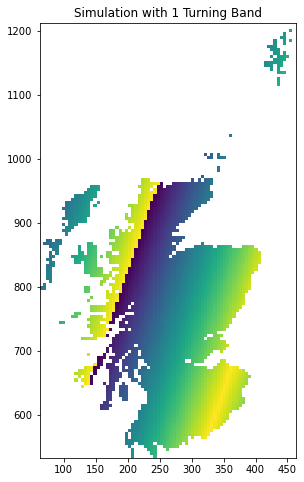

In [8]:
ax = target.plot("Simu1")
ax.decoration(title="Simulation with 1 Turning Band")

Let us now simulate the model using 10 turning bands.

In [9]:
err = gl.simtub(dbout=target, model=fitmod, 
             nbsimu=1,
             nbtuba=10, seed=12454,
             namconv=gl.NamingConvention("Simu10"))

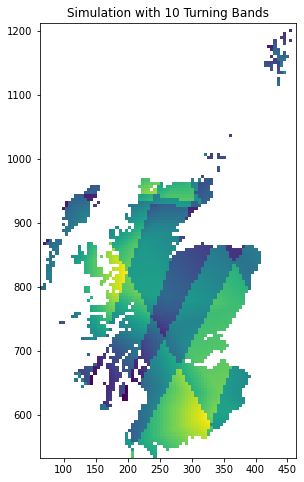

In [10]:
ax = target.plot("Simu10")
ax.decoration(title="Simulation with 10 Turning Bands")

Let us now simulate the model using 1000 turning bands.

In [11]:
err = gl.simtub(dbout=target, model=fitmod, 
             nbsimu=1,
             nbtuba=1000, seed=12454,
             namconv=gl.NamingConvention("Simu1000"))

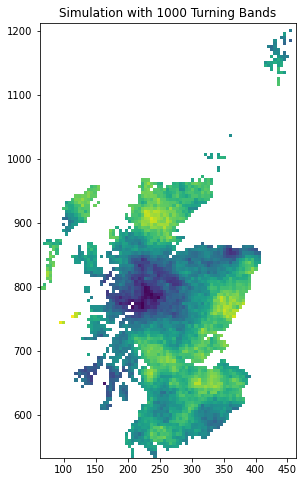

In [12]:
ax = target.plot("Simu1000")
ax.decoration(title="Simulation with 1000 Turning Bands")

## Conditional Simulations

To perform conditional simulations, we use the same command as for unconditional simulations. We just need to supply two additional arguments: the data base containing the conditioning data (argument `dbin`), and the type of neighborhood used when conditioning the simulations (since this is done using kriging).

Circling back to our example, let us consider the temperature observations in the data base `dat` as conditioning points. Our aim is to generate simulations of the model `fitmod` that honor these data. 

We first must control that our data follow more or less a gaussian distribution.

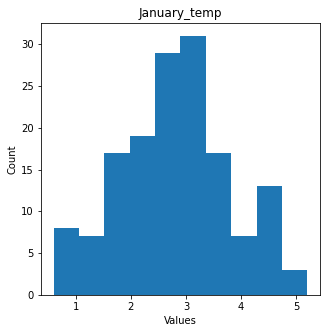

In [18]:
fig, ax = gp.init()
ax.histogram(dat, name="January_temp",bins=10)
plt.show()

Then, we compute the mean of temperature observations and set it as the mean of the model, so that the future simulations of the model also share this mean.

In [ ]:
## Compute mean temperature
mean_Temperature = gl.dbStatisticsMono(dat, ["J*temp"], [gl.EStatOption.MEAN])
print("Mean of observed temperatures:", mean_Temperature)

## Add to model
fitmod.setMeans(mean_Temperature)

Then, to generate 10 conditional simulations using 1000 turning bands, we can simply run:

In [ ]:
# Parameters
nbsimu = 10
nbtuba = 1000
seed   = 13231

# Simulation
err = gl.simtub(dbin=dat, dbout=target,
             model=fitmod, 
             neigh=neighU,
             nbsimu=nbsimu,
             nbtuba=nbtuba, seed=seed)

Let us display a few simulation results.

In [ ]:
fig, ax = plt.subplots(2,2, figsize=[12,14])
ax[0,0].raster(target,name="Simu*temp.1")
ax[0,0].symbol(dat, flagCst=True, c="black")
ax[0,1].raster(target,name="Simu*temp.2")
ax[0,1].symbol(dat, flagCst=True, c="black")
ax[1,0].raster(target,name="Simu*temp.3")
ax[1,0].symbol(dat, flagCst=True, c="black")
ax[1,1].raster(target,name="Simu*temp.4")
ax[1,1].symbol(dat, flagCst=True, c="black")
fig.subplots_adjust(right=0.7)
cbar_ax = fig.add_axes([0.75, 0.1, 0.02, 0.75])
im = ax[0,0].collections[0]
err = fig.colorbar(im, cax = cbar_ax)

Let us now compute the mean of the simulations we just generated. To do so, we use the `statistics` method of the `Db` class.

In [ ]:
err = target.statistics(names=["Simu.January_temp*"], 
                        opers=[gl.EStatOption.MEAN],
                        flagStoreInDb=True)

Let us compare the mean of the simulations with result from a simple kriging prediction of the temperature.

In [ ]:
err = gl.kriging(dat, target, model=fitmod, 
              neigh = neighU,
              namconv=gl.NamingConvention("KS"))

In [ ]:
ax = gp.correlation(target, namex="Stats.MEAN", namey="KS*estim", diagLine=True, bins=100, cmin=1)
ax.decoration(xlabel="Mean of Simulations", ylabel="Simple Kriging Estimate",
             title="Correlation plot")

## Simulations with External Drift

In this section, we show how to simulate a model with external drifts. To do so, it suffices to call the `simtub` function with a `Model` object that includes external drifts.

Let us build such a model, to illustrate our point. We start by reloading the two data bases of the Preambule.

In [ ]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Temperatures.NF'
temp_nf, head = urllib.request.urlretrieve(url)
dat = gl.Db.createFromNF(temp_nf)

url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Elevations.NF'
elev_nf, head = urllib.request.urlretrieve(url)
target = gl.DbGrid.createFromNF(elev_nf)

We will consider the temperature as our variable of interest, and the elevation as an external drift. Hence, we set the elevation variable to a `f` locator in both data bases.

In [ ]:
## Set `f` locator to elevation in `dat` data base
dat.setLocator("Elevation", gl.ELoc.F)

## Set `f` locator to elevation in `target` data base
target.setLocator("Elevation", gl.ELoc.F)

In [ ]:
## Create with external drift
model_ED = gl.Model()
model_ED.setDriftIRF(order=0, nfex = 1)

## Create experimental variogram of residuals
vario_resED = gl.Vario.create(varioparam, dat)
vario_resED.compute(model=model_ED)

## Fit model on experimental variogram 
err = model_ED.fit(vario_resED, types=[gl.ECov.SPHERICAL, gl.ECov.CUBIC])

Let us plot the fitted model (solid line) together with the experimental variogram (dashed line).

In [ ]:
ax = gp.varmod(vario_resED, model_ED)

Now, to generate 10 conditional simulations from the model with external drift that we just create, we call the `simtub` function with the same synthax as before.

In [ ]:
err = gl.simtub(dbin=dat, dbout=target, model=model_ED, 
             neigh=neighU,
             nbsimu=nbsimu,
             nbtuba=nbtuba, seed=seed)

Let us display a few simulation results.

In [ ]:
fig, ax = plt.subplots(2,2, figsize=[12,14])
ax[0,0].raster(target,name="Simu*temp.1")
ax[0,0].symbol(dat, flagCst=True, c="black")
ax[0,1].raster(target,name="Simu*temp.2")
ax[0,1].symbol(dat, flagCst=True, c="black")
ax[1,0].raster(target,name="Simu*temp.3")
ax[1,0].symbol(dat, flagCst=True, c="black")
ax[1,1].raster(target,name="Simu*temp.4")
ax[1,1].symbol(dat, flagCst=True, c="black")
fig.subplots_adjust(right=0.7)
cbar_ax = fig.add_axes([0.75, 0.1, 0.02, 0.75])
im = ax[0,0].collections[0]
err = fig.colorbar(im, cax = cbar_ax)

Let us now compute the mean of the simulations we just generated, and compare it with a prediction by kriging with external drift.

In [ ]:
err = target.statistics(names=["Simu.January_temp*"], 
                        opers=[gl.EStatOption.MEAN],
                        flagStoreInDb=True)

## Compute kriging
err = gl.kriging(dat, target, model=model_ED, 
              neigh = neighU,
              namconv=gl.NamingConvention("KED"))

In [ ]:
ax = gp.correlation(target, namex="Stats.MEAN", namey="KED*estim", diagLine=True, bins=100, cmin=1)
ax.decoration(xlabel="Mean of Simulations", ylabel="Kriging with External Drift")

## Application : Probability of exceedence 

As an application, we show how to compute maps probabilities of exceeding a threshold. For instance, to compute the probabilities of being positive, we start by turning the simulation results into binary variables taking the value 1 if the simulated value is positive and 0 otherwise. Then, the probability of being positive is computed as the mean of these binary variables.

In [ ]:
## Turn simulation results into binary variable
target["Simu.January_temp*"] = target["Simu.January_temp*"] > 0

## Average binary variables
err = target.statistics(names=["Simu.January_temp*"], 
                        opers=[gl.EStatOption.MEAN],
                        flagStoreInDb=True,
                        namconv=gl.NamingConvention("Proba"))

Let us plot the results.

In [ ]:
ax = target.plot("Proba.MEAN", flagLegendRaster=True)
ax.decoration(title="Probability for positive Temperatures")